## Загрузка библиотек

In [ ]:
pip install w3lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

# Доп. библиотеки
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
import copy
from tqdm import tqdm
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

drive.mount('/content/drive/')
main_path = "/content/drive/MyDrive/Университет/ТОБД/2 семестр/Задание 7/"
os.chdir(main_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Объявление функций

In [ ]:
# v2

def number_of_correct_ans(y_hat, y):
  # Считаем кол-во верных ответов (работает для ответов - векторов)
  y_hat = y_hat.argmax(axis=1)
  correct_mask = y_hat == y
  return correct_mask.sum()


def evaluate_accuracy(net, test_iter):

  # Выставляем режим оценки модели
  net.eval()

  total_samples = len(test_iter.dataset) #Общее кол-во элементво в выборке
  correct_ans = 0

  with torch.no_grad():
    for X, y in test_iter:
      X, y = X.to(device), y.to(device)

      y_hat = net(X)
      correct_ans += number_of_correct_ans(y_hat, y)

  return correct_ans / total_samples


def train_epoch(net, train_iter, loss, updater, clip_value):

  # Выставляем режим обучения модели
  net.train()

  total_samples = len(train_iter.dataset)
  correct_samples = 0
  total_loss = 0

  for X, y in train_iter:
    X, y = X.to(device), y.to(device)

    y_hat = net(X)
    l = loss(y_hat, y)

    updater.zero_grad()
    l.backward()
    if clip_value:
      torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)
    updater.step()

    total_loss += l
    correct_samples += number_of_correct_ans(y_hat, y)

  return total_loss / total_samples, correct_samples / total_samples


class Model_metrics:
  def __init__(self):
    self.train_loss = []
    self.train_accuracy = []
    self.test_accuracy = []

  def add(self, train_loss, train_accuracy, test_accuracy):
      self.train_loss.append(train_loss.cpu().item())
      self.train_accuracy.append(train_accuracy.cpu().item())
      self.test_accuracy.append(test_accuracy.cpu().item())

  def plot(self):
      plt.rcParams.update({'font.size': 12})
      fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
      epochs = np.arange(len(self.train_loss))

      # График функции потерь
      ax[0].plot(epochs, self.train_loss, label="train loss")
      ax[0].set_xticks(epochs)
      ax[0].grid()
      ax[0].legend()

      # График точности на обучении и тесте
      ax[1].plot(epochs, self.train_accuracy, label="train accuracy")
      ax[1].plot(epochs, self.test_accuracy, label="test accuracy")
      ax[1].set_xticks(epochs)
      ax[1].grid()
      ax[1].legend()

      plt.show()


  def return_dict(self):
    res = {
        "train_loss": self.train_loss,
        "train_accuracy": self.train_accuracy,
        "test_accuracy": self.test_accuracy
    }
    return res


def saving(net, model_metrics, path):
  state = {"state_dict": net.state_dict()}
  metrics_dict = model_metrics.return_dict()
  state = {**state, **metrics_dict}
  torch.save(state, path)


def train_rnn_model(net, train_iter, test_iter, loss,
                num_epochs, updater, clip_value = None, path=None):

  model_metrics = Model_metrics()
  for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train_epoch(net, train_iter, loss, updater, clip_value)
    test_accuracy = evaluate_accuracy(net, test_iter)
    model_metrics.add(train_loss, train_accuracy, test_accuracy)
    print (f': Loss: {train_loss:.4f}, Train acc: {train_accuracy:.4f}, Test acc: {test_accuracy:.4f}')
  model_metrics.plot()
  if path:
    saving(net, model_metrics, path)


## 1. Классификация фамилий (RNN)

Датасет: https://disk.yandex.ru/d/frNchuaBQVLxyA?w=1

1.1 Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса `RNN`. Используя созданный класс `RNN`, решите задачу классификации фамилий. 


In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size):
      super().__init__()
      self.rnn_cell=nn.RNNCell(input_size,hidden_size)
      self.hidden_size=hidden_size
      self.input_size=input_size
  def forward(self, x, h=None):
    batch_size,seq_size,emb_size=x.shape
    # инициализация тензора скрытых состояний
    # h = ...
    if h is None:
        h=torch.zeros(batch_size, self.hidden_size).to(device=x.device)
    output = torch.zeros(batch_size, seq_size, self.hidden_size).to(device=x.device)
    # проход по каждому элементу последовательностей s в батче и обновление скрытого состояния
    for t in range(seq_size):
         h = self.rnn_cell(x[:, t, :], h)
         output[:, t, :] = h
    return (output, h)
    # вернуть тензор всех наблюдавшихся скрытых состояний размера (batch_size, seq_len, hidden_size) и тензор скрытых состояний в последний момент времени

In [ ]:
batch_size, seq_len, embedding_size, hidden_size = 5, 5, 7, 10
X = torch.rand(batch_size, seq_len, embedding_size)
rnn = RNN(embedding_size, hidden_size)

In [ ]:
train_surnames = pd.read_csv("../Задание 5/data/surnames.csv")
class_encoder = LabelEncoder()
train_surnames['nationality'] = class_encoder.fit_transform(train_surnames['nationality'])

X = train_surnames['surname'].str.lower()
y = train_surnames['nationality']
n_classes = y.nunique()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
print(n_classes)

18


In [ ]:
class Vocab:
     def __init__(self, data):
        tokens = set()
        self.max_seq_len = 0
        for item in data:
            tokens.update(item)
            self.max_seq_len = max(self.max_seq_len, len(item))
        self.unk_token = '<UNK>'
        self.pad_token = '<PAD>'
        self.idx_to_token = dict(enumerate(tokens, 2))
        self.idx_to_token[1] = self.unk_token
        self.idx_to_token[0] = self.pad_token
        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)
class SurnamesDataset(Dataset):
    def __init__(self, X, y, vocab):
                     self.X = X
                     self.y = y
                     self.vocab = vocab
    def to_sequence(self, surname):
        tok_seq = [self.vocab.token_to_idx[tok] for tok in surname]
        padds_len = self.vocab.max_seq_len - len(tok_seq)
        pad_idx = self.vocab.token_to_idx[self.vocab.pad_token]
        padds = [pad_idx] * padds_len
        return torch.LongTensor(tok_seq + padds)
    def __len__(self):
      return len(self.X)
    def __getitem__(self, idx):
      return self.to_sequence(self.X.iloc[idx]), self.y.iloc[idx]


In [ ]:
vocab = Vocab(X)
train_dataset = SurnamesDataset(X_train, y_train, vocab)
test_dataset = SurnamesDataset(X_test, y_test, vocab)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

### Custom RNN

In [ ]:
class RNNClassifierCustomRNN(nn.Module):
  def __init__(self, vocab_len, embedding_size, rnn_hidden_size, num_classes):
    super().__init__()
    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = RNN(embedding_size, rnn_hidden_size)
    self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size, rnn_hidden_size),nn.ReLU(), nn.Dropout(0.5), nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.5)
  
  def forward(self, X):
    out = self.embedding(X) # batch x seq x emb
    out = torch.squeeze(self.rnn(out)[1]) # batch x rnn_hidden
    out = self.dropout(out) # batch x rnn_hidden
    out = self.classifier(out) # batch x num_classes
    return out


In [ ]:
vocab_len = vocab.vocab_len
embedding_size = 30
rnn_hidden_size = 256
num_classes = n_classes
net = RNNClassifierCustomRNN(vocab_len, embedding_size, rnn_hidden_size, num_classes)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)

task_path = "./Saved models/"
file_name = "Surname_task_main.pt"
num_epochs = 20 

 20%|██        | 1/5 [00:03<00:13,  3.36s/it]

: Loss: 0.0104, Train acc: 0.6457, Test acc: 0.6471


 40%|████      | 2/5 [00:06<00:09,  3.23s/it]

: Loss: 0.0098, Train acc: 0.6658, Test acc: 0.6585


 60%|██████    | 3/5 [00:09<00:05,  2.90s/it]

: Loss: 0.0093, Train acc: 0.6770, Test acc: 0.6607


 80%|████████  | 4/5 [00:11<00:02,  2.72s/it]

: Loss: 0.0090, Train acc: 0.6876, Test acc: 0.6708


100%|██████████| 5/5 [00:13<00:00,  2.78s/it]

: Loss: 0.0088, Train acc: 0.6915, Test acc: 0.6790


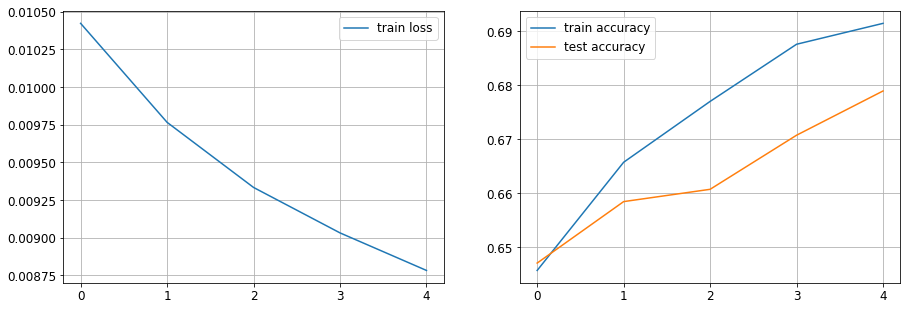

In [ ]:
#Обучение сети
path = "./Saved models/Surname_task_main.pt"
num_epochs = 5
train_model(net, train_loader, test_loader, loss, num_epochs, updater, path)

  5%|▌         | 1/20 [00:02<00:50,  2.68s/it]

: Loss: 0.0183, Train acc: 0.2509, Test acc: 0.2582


 10%|█         | 2/20 [00:05<00:47,  2.62s/it]

: Loss: 0.0176, Train acc: 0.2645, Test acc: 0.2582


 15%|█▌        | 3/20 [00:07<00:44,  2.62s/it]

: Loss: 0.0167, Train acc: 0.3319, Test acc: 0.4290


 20%|██        | 4/20 [00:10<00:41,  2.60s/it]

: Loss: 0.0146, Train acc: 0.4664, Test acc: 0.5009


 25%|██▌       | 5/20 [00:12<00:38,  2.58s/it]

: Loss: 0.0137, Train acc: 0.5052, Test acc: 0.4991


 30%|███       | 6/20 [00:15<00:35,  2.57s/it]

: Loss: 0.0130, Train acc: 0.5434, Test acc: 0.5533


 35%|███▌      | 7/20 [00:18<00:33,  2.58s/it]

: Loss: 0.0120, Train acc: 0.5857, Test acc: 0.6043


 40%|████      | 8/20 [00:20<00:30,  2.58s/it]

: Loss: 0.0111, Train acc: 0.6190, Test acc: 0.6175


 45%|████▌     | 9/20 [00:23<00:28,  2.58s/it]

: Loss: 0.0103, Train acc: 0.6426, Test acc: 0.6339


 50%|█████     | 10/20 [00:25<00:25,  2.57s/it]

: Loss: 0.0098, Train acc: 0.6629, Test acc: 0.6557


 55%|█████▌    | 11/20 [00:28<00:23,  2.57s/it]

: Loss: 0.0090, Train acc: 0.6815, Test acc: 0.6653


 60%|██████    | 12/20 [00:30<00:20,  2.56s/it]

: Loss: 0.0085, Train acc: 0.6926, Test acc: 0.6903


 65%|██████▌   | 13/20 [00:33<00:17,  2.57s/it]

: Loss: 0.0083, Train acc: 0.6995, Test acc: 0.6749


 70%|███████   | 14/20 [00:36<00:15,  2.56s/it]

: Loss: 0.0079, Train acc: 0.7106, Test acc: 0.6944


 75%|███████▌  | 15/20 [00:38<00:12,  2.57s/it]

: Loss: 0.0074, Train acc: 0.7300, Test acc: 0.6981


 80%|████████  | 16/20 [00:41<00:10,  2.56s/it]

: Loss: 0.0072, Train acc: 0.7327, Test acc: 0.6990


 85%|████████▌ | 17/20 [00:43<00:07,  2.56s/it]

: Loss: 0.0070, Train acc: 0.7480, Test acc: 0.7036


 90%|█████████ | 18/20 [00:46<00:05,  2.56s/it]

: Loss: 0.0068, Train acc: 0.7472, Test acc: 0.6972


 95%|█████████▌| 19/20 [00:48<00:02,  2.57s/it]

: Loss: 0.0065, Train acc: 0.7601, Test acc: 0.7122


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]

: Loss: 0.0062, Train acc: 0.7638, Test acc: 0.7086


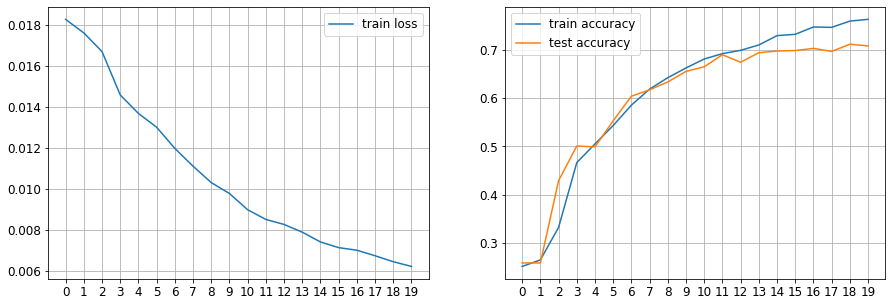

In [ ]:
#Обучение сети
train_model(net, train_loader, test_loader, loss, num_epochs, updater, task_path, file_name)

1.2 Замените модуль `RNN` из 1.1 на модули `nn.RNN`, `nn.LSTM` и `nn.GRU` (не забудьте указать аргумент `batch_first=True`). Сравните результаты работы.

### nn.RNN

In [ ]:
class RNNClassifierCustomRNN(nn.Module):
 def __init__(self, vocab_len, embedding_size, rnn_hidden_size, num_classes):
    super().__init__()
    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.RNN(embedding_size, rnn_hidden_size, batch_first=True)
    self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size, rnn_hidden_size),nn.ReLU(), nn.Dropout(0.5), nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.5)
 def forward(self, X):
  out = self.embedding(X) # batch x seq x emb
  out = torch.squeeze(self.rnn(out)[1]) # batch x rnn_hidden
  out = self.dropout(out) # batch x rnn_hidden
  out = self.classifier(out) # batch x num_classes
  return out


vocab_len = vocab.vocab_len
embedding_size = 30
rnn_hidden_size = 256
num_classes = n_classes
net = RNNClassifierCustomRNN(vocab_len, embedding_size, rnn_hidden_size, num_classes)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)

task_path = "./Saved models/"
file_name = "Surname_task_nn_RNN.pt"
num_epochs = 25 

  4%|▍         | 1/25 [00:02<01:10,  2.92s/it]

: Loss: 0.0184, Train acc: 0.2436, Test acc: 0.2582


  8%|▊         | 2/25 [00:05<01:06,  2.91s/it]

: Loss: 0.0177, Train acc: 0.2642, Test acc: 0.2582


 12%|█▏        | 3/25 [00:08<01:03,  2.90s/it]

: Loss: 0.0176, Train acc: 0.2671, Test acc: 0.2618


 16%|█▌        | 4/25 [00:11<01:00,  2.90s/it]

: Loss: 0.0167, Train acc: 0.3166, Test acc: 0.3866


 20%|██        | 5/25 [00:14<00:57,  2.90s/it]

: Loss: 0.0150, Train acc: 0.4472, Test acc: 0.4991


 24%|██▍       | 6/25 [00:17<00:55,  2.91s/it]

: Loss: 0.0135, Train acc: 0.5305, Test acc: 0.5556


 28%|██▊       | 7/25 [00:20<00:52,  2.90s/it]

: Loss: 0.0124, Train acc: 0.5693, Test acc: 0.6120


 32%|███▏      | 8/25 [00:23<00:49,  2.89s/it]

: Loss: 0.0112, Train acc: 0.6133, Test acc: 0.6216


 36%|███▌      | 9/25 [00:26<00:46,  2.89s/it]

: Loss: 0.0104, Train acc: 0.6438, Test acc: 0.6576


 40%|████      | 10/25 [00:28<00:43,  2.88s/it]

: Loss: 0.0096, Train acc: 0.6668, Test acc: 0.6603


 44%|████▍     | 11/25 [00:31<00:40,  2.89s/it]

: Loss: 0.0091, Train acc: 0.6824, Test acc: 0.6671


 48%|████▊     | 12/25 [00:34<00:37,  2.88s/it]

: Loss: 0.0086, Train acc: 0.6950, Test acc: 0.6781


 52%|█████▏    | 13/25 [00:37<00:34,  2.88s/it]

: Loss: 0.0084, Train acc: 0.6956, Test acc: 0.6926


 56%|█████▌    | 14/25 [00:40<00:31,  2.89s/it]

: Loss: 0.0079, Train acc: 0.7157, Test acc: 0.6931


 60%|██████    | 15/25 [00:43<00:28,  2.90s/it]

: Loss: 0.0076, Train acc: 0.7294, Test acc: 0.6881


 64%|██████▍   | 16/25 [00:46<00:26,  2.89s/it]

: Loss: 0.0074, Train acc: 0.7311, Test acc: 0.6990


 68%|██████▊   | 17/25 [00:49<00:23,  2.89s/it]

: Loss: 0.0073, Train acc: 0.7321, Test acc: 0.6922


 72%|███████▏  | 18/25 [00:52<00:20,  2.88s/it]

: Loss: 0.0070, Train acc: 0.7403, Test acc: 0.7090


 76%|███████▌  | 19/25 [00:54<00:17,  2.89s/it]

: Loss: 0.0068, Train acc: 0.7474, Test acc: 0.7049


 80%|████████  | 20/25 [00:57<00:14,  2.88s/it]

: Loss: 0.0066, Train acc: 0.7583, Test acc: 0.6995


 84%|████████▍ | 21/25 [01:00<00:11,  2.87s/it]

: Loss: 0.0063, Train acc: 0.7643, Test acc: 0.6926


 88%|████████▊ | 22/25 [01:03<00:08,  2.88s/it]

: Loss: 0.0062, Train acc: 0.7709, Test acc: 0.7054


 92%|█████████▏| 23/25 [01:06<00:05,  2.87s/it]

: Loss: 0.0059, Train acc: 0.7793, Test acc: 0.7067


 96%|█████████▌| 24/25 [01:09<00:02,  2.88s/it]

: Loss: 0.0057, Train acc: 0.7842, Test acc: 0.7067


100%|██████████| 25/25 [01:12<00:00,  2.89s/it]

: Loss: 0.0054, Train acc: 0.7964, Test acc: 0.7199


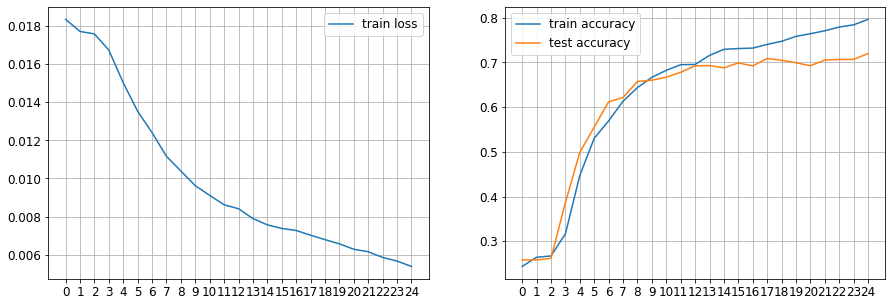

In [ ]:
#Обучение сети
train_model(net, train_loader, test_loader, loss, num_epochs, updater, task_path, file_name)

### nn.LSTM

In [ ]:
class RNNClassifierCustomRNN(nn.Module):
 def __init__(self, vocab_len, embedding_size, rnn_hidden_size, num_classes):
    super().__init__()
    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.LSTM(embedding_size, rnn_hidden_size, batch_first=True)
    self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size, rnn_hidden_size),nn.ReLU(), nn.Dropout(0.5), nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.5)
 def forward(self, X):
  out = self.embedding(X) # batch x seq x emb
  out = torch.squeeze(self.rnn(out)[1][0]) # batch x rnn_hidden
  out = self.dropout(out) # batch x rnn_hidden
  out = self.classifier(out) # batch x num_classes
  return out


vocab_len = vocab.vocab_len
embedding_size = 30
rnn_hidden_size = 256
num_classes = n_classes
net = RNNClassifierCustomRNN(vocab_len, embedding_size, rnn_hidden_size, num_classes)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)

task_path = "./Saved models/"
file_name = "Surname_task_nn_LSTM.pt"
num_epochs = 25 

  4%|▍         | 1/25 [00:08<03:25,  8.56s/it]

: Loss: 0.0184, Train acc: 0.2531, Test acc: 0.2582


  8%|▊         | 2/25 [00:16<03:06,  8.13s/it]

: Loss: 0.0165, Train acc: 0.3386, Test acc: 0.4053


 12%|█▏        | 3/25 [00:24<03:00,  8.18s/it]

: Loss: 0.0149, Train acc: 0.4277, Test acc: 0.4795


 16%|█▌        | 4/25 [00:32<02:51,  8.17s/it]

: Loss: 0.0130, Train acc: 0.5242, Test acc: 0.5679


 20%|██        | 5/25 [00:41<02:45,  8.29s/it]

: Loss: 0.0119, Train acc: 0.5729, Test acc: 0.5902


 24%|██▍       | 6/25 [00:49<02:37,  8.27s/it]

: Loss: 0.0107, Train acc: 0.6132, Test acc: 0.6234


 28%|██▊       | 7/25 [00:57<02:29,  8.33s/it]

: Loss: 0.0099, Train acc: 0.6467, Test acc: 0.6448


 32%|███▏      | 8/25 [01:06<02:21,  8.32s/it]

: Loss: 0.0092, Train acc: 0.6712, Test acc: 0.6762


 36%|███▌      | 9/25 [01:14<02:14,  8.43s/it]

: Loss: 0.0087, Train acc: 0.6889, Test acc: 0.6781


 40%|████      | 10/25 [01:23<02:07,  8.49s/it]

: Loss: 0.0083, Train acc: 0.7015, Test acc: 0.6917


 44%|████▍     | 11/25 [01:31<01:57,  8.41s/it]

: Loss: 0.0078, Train acc: 0.7160, Test acc: 0.6862


 48%|████▊     | 12/25 [01:39<01:48,  8.34s/it]

: Loss: 0.0075, Train acc: 0.7250, Test acc: 0.7099


 52%|█████▏    | 13/25 [01:48<01:40,  8.40s/it]

: Loss: 0.0072, Train acc: 0.7368, Test acc: 0.7281


 56%|█████▌    | 14/25 [01:56<01:32,  8.37s/it]

: Loss: 0.0071, Train acc: 0.7423, Test acc: 0.7377


 60%|██████    | 15/25 [02:05<01:23,  8.38s/it]

: Loss: 0.0066, Train acc: 0.7532, Test acc: 0.7386


 64%|██████▍   | 16/25 [02:13<01:15,  8.41s/it]

: Loss: 0.0065, Train acc: 0.7582, Test acc: 0.7327


 68%|██████▊   | 17/25 [02:21<01:06,  8.30s/it]

: Loss: 0.0062, Train acc: 0.7667, Test acc: 0.7559


 72%|███████▏  | 18/25 [02:30<00:58,  8.33s/it]

: Loss: 0.0060, Train acc: 0.7747, Test acc: 0.7354


 76%|███████▌  | 19/25 [02:38<00:50,  8.38s/it]

: Loss: 0.0060, Train acc: 0.7750, Test acc: 0.7368


 80%|████████  | 20/25 [02:46<00:41,  8.36s/it]

: Loss: 0.0057, Train acc: 0.7823, Test acc: 0.7505


 84%|████████▍ | 21/25 [02:56<00:34,  8.65s/it]

: Loss: 0.0054, Train acc: 0.7943, Test acc: 0.7582


 88%|████████▊ | 22/25 [03:04<00:25,  8.48s/it]

: Loss: 0.0053, Train acc: 0.7997, Test acc: 0.7404


 92%|█████████▏| 23/25 [03:12<00:16,  8.35s/it]

: Loss: 0.0050, Train acc: 0.8058, Test acc: 0.7564


 96%|█████████▌| 24/25 [03:20<00:08,  8.30s/it]

: Loss: 0.0048, Train acc: 0.8114, Test acc: 0.7450


100%|██████████| 25/25 [03:28<00:00,  8.35s/it]

: Loss: 0.0047, Train acc: 0.8131, Test acc: 0.7400


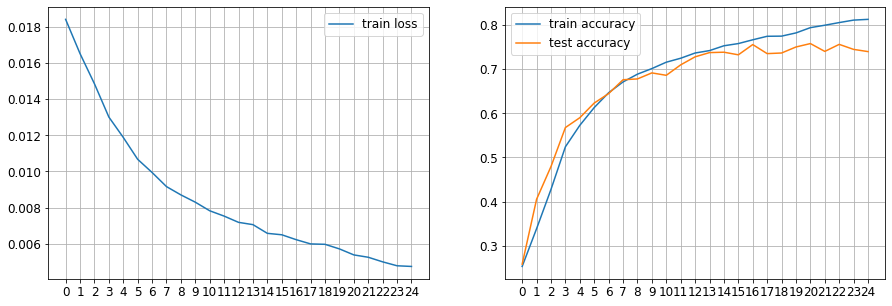

In [ ]:
#Обучение сети
train_model(net, train_loader, test_loader, loss, num_epochs, updater, task_path, file_name)

### GRU - last state

In [ ]:
class RNNClassifierCustomRNN(nn.Module):
 def __init__(self, vocab_len, embedding_size, rnn_hidden_size, num_classes):
    super().__init__()
    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.GRU(embedding_size, rnn_hidden_size, batch_first=True)
    self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size, rnn_hidden_size),nn.ReLU(), nn.Dropout(0.5), nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.5)
 def forward(self, X):
  out = self.embedding(X) # batch x seq x emb
  out = torch.squeeze(self.rnn(out)[1]) # batch x rnn_hidden
  out = self.dropout(out) # batch x rnn_hidden
  out = self.classifier(out) # batch x num_classes
  return out


vocab_len = vocab.vocab_len
embedding_size = 30
rnn_hidden_size = 256
num_classes = n_classes
net = RNNClassifierCustomRNN(vocab_len, embedding_size, rnn_hidden_size, num_classes)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)

task_path = "./Saved models/"
file_name = "Surname_task_nn_GRU.pt"
num_epochs = 25 

  4%|▍         | 1/25 [00:06<02:43,  6.82s/it]

: Loss: 0.0180, Train acc: 0.2548, Test acc: 0.2996


  8%|▊         | 2/25 [00:13<02:32,  6.64s/it]

: Loss: 0.0152, Train acc: 0.4076, Test acc: 0.5100


 12%|█▏        | 3/25 [00:19<02:21,  6.41s/it]

: Loss: 0.0128, Train acc: 0.5331, Test acc: 0.5874


 16%|█▌        | 4/25 [00:25<02:14,  6.38s/it]

: Loss: 0.0115, Train acc: 0.5846, Test acc: 0.6052


 20%|██        | 5/25 [00:32<02:09,  6.48s/it]

: Loss: 0.0104, Train acc: 0.6206, Test acc: 0.6516


 24%|██▍       | 6/25 [00:39<02:03,  6.50s/it]

: Loss: 0.0092, Train acc: 0.6663, Test acc: 0.6644


 28%|██▊       | 7/25 [00:46<02:05,  6.96s/it]

: Loss: 0.0086, Train acc: 0.6849, Test acc: 0.6758


 32%|███▏      | 8/25 [00:53<01:54,  6.75s/it]

: Loss: 0.0080, Train acc: 0.7081, Test acc: 0.6949


 36%|███▌      | 9/25 [00:59<01:46,  6.67s/it]

: Loss: 0.0074, Train acc: 0.7251, Test acc: 0.7045


 40%|████      | 10/25 [01:06<01:40,  6.71s/it]

: Loss: 0.0070, Train acc: 0.7362, Test acc: 0.7113


 44%|████▍     | 11/25 [01:14<01:41,  7.25s/it]

: Loss: 0.0068, Train acc: 0.7450, Test acc: 0.7300


 48%|████▊     | 12/25 [01:21<01:31,  7.01s/it]

: Loss: 0.0064, Train acc: 0.7577, Test acc: 0.7354


 52%|█████▏    | 13/25 [01:27<01:22,  6.87s/it]

: Loss: 0.0059, Train acc: 0.7740, Test acc: 0.7441


 56%|█████▌    | 14/25 [01:34<01:13,  6.68s/it]

: Loss: 0.0057, Train acc: 0.7828, Test acc: 0.7395


 60%|██████    | 15/25 [01:40<01:05,  6.54s/it]

: Loss: 0.0054, Train acc: 0.7936, Test acc: 0.7491


 64%|██████▍   | 16/25 [01:46<00:58,  6.45s/it]

: Loss: 0.0051, Train acc: 0.7992, Test acc: 0.7587


 68%|██████▊   | 17/25 [01:53<00:51,  6.45s/it]

: Loss: 0.0047, Train acc: 0.8117, Test acc: 0.7555


 72%|███████▏  | 18/25 [01:59<00:45,  6.53s/it]

: Loss: 0.0045, Train acc: 0.8229, Test acc: 0.7596


 76%|███████▌  | 19/25 [02:06<00:39,  6.52s/it]

: Loss: 0.0042, Train acc: 0.8352, Test acc: 0.7605


 80%|████████  | 20/25 [02:12<00:32,  6.49s/it]

: Loss: 0.0040, Train acc: 0.8436, Test acc: 0.7591


 84%|████████▍ | 21/25 [02:19<00:25,  6.48s/it]

: Loss: 0.0037, Train acc: 0.8508, Test acc: 0.7628


 88%|████████▊ | 22/25 [02:25<00:19,  6.46s/it]

: Loss: 0.0034, Train acc: 0.8627, Test acc: 0.7527


 92%|█████████▏| 23/25 [02:31<00:12,  6.41s/it]

: Loss: 0.0032, Train acc: 0.8718, Test acc: 0.7514


 96%|█████████▌| 24/25 [02:38<00:06,  6.31s/it]

: Loss: 0.0031, Train acc: 0.8770, Test acc: 0.7477


100%|██████████| 25/25 [02:44<00:00,  6.59s/it]

: Loss: 0.0030, Train acc: 0.8818, Test acc: 0.7477


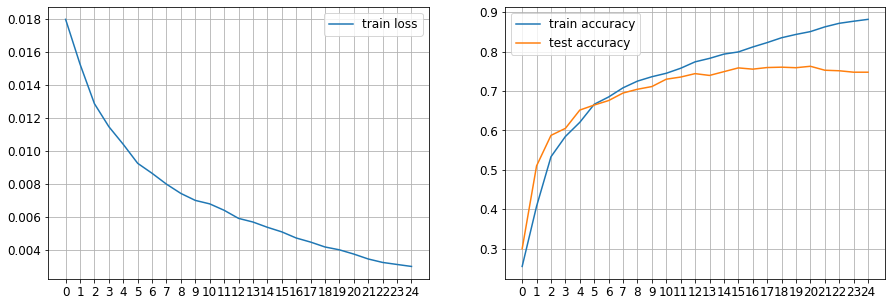

In [ ]:
#Обучение сети
train_model(net, train_loader, test_loader, loss, num_epochs, updater, task_path, file_name)

### GRU - concat

In [ ]:
class RNNClassifierCustomRNN(nn.Module):
  def __init__(self, vocab_len, embedding_size, rnn_hidden_size, num_classes, seq_len):
    super().__init__()
    self.hidden_dim = rnn_hidden_size
    self.seq_len = seq_len
    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.GRU(embedding_size, rnn_hidden_size, batch_first=True)
    self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size * seq_len, rnn_hidden_size),nn.ReLU(), nn.Dropout(0.5), nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.5)
    
  def forward(self, X):
    h0 = torch.zeros(1, X.size(0), self.hidden_dim).to(device)
    batch_size = X.shape[0]

    emb = self.embedding(X) # batch x seq x emb
    out, hidden = self.rnn(emb, h0)
    out = out.reshape(batch_size, self.hidden_dim * self.seq_len)
    out = self.dropout(out) # batch x rnn_hidden
    out = self.classifier(out) # batch x num_classes
    return out


vocab_len = vocab.vocab_len
embedding_size = 30
rnn_hidden_size = 256
num_classes = n_classes
seq_len = vocab.max_seq_len
net = RNNClassifierCustomRNN(vocab_len, embedding_size, rnn_hidden_size, num_classes, seq_len)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)
clip_value = 5

path = "./Saved models/Surname_task_nn_GRU.pt"
num_epochs = 15

  7%|▋         | 1/15 [00:10<02:24, 10.31s/it]

: Loss: 0.0142, Train acc: 0.4837, Test acc: 0.5974


 13%|█▎        | 2/15 [00:19<02:01,  9.38s/it]

: Loss: 0.0102, Train acc: 0.6179, Test acc: 0.6557


 20%|██        | 3/15 [00:27<01:48,  9.03s/it]

: Loss: 0.0086, Train acc: 0.6755, Test acc: 0.7081


 27%|██▋       | 4/15 [00:38<01:48,  9.87s/it]

: Loss: 0.0074, Train acc: 0.7198, Test acc: 0.7327


 33%|███▎      | 5/15 [00:47<01:34,  9.42s/it]

: Loss: 0.0065, Train acc: 0.7474, Test acc: 0.7564


 40%|████      | 6/15 [00:56<01:22,  9.14s/it]

: Loss: 0.0059, Train acc: 0.7674, Test acc: 0.7655


 47%|████▋     | 7/15 [01:04<01:11,  8.94s/it]

: Loss: 0.0054, Train acc: 0.7873, Test acc: 0.7682


 53%|█████▎    | 8/15 [01:13<01:02,  8.91s/it]

: Loss: 0.0050, Train acc: 0.7994, Test acc: 0.7587


 60%|██████    | 9/15 [01:23<00:56,  9.40s/it]

: Loss: 0.0045, Train acc: 0.8124, Test acc: 0.7696


 67%|██████▋   | 10/15 [01:32<00:45,  9.18s/it]

: Loss: 0.0042, Train acc: 0.8234, Test acc: 0.7728


 73%|███████▎  | 11/15 [01:41<00:36,  9.02s/it]

: Loss: 0.0039, Train acc: 0.8375, Test acc: 0.7760


 80%|████████  | 12/15 [01:52<00:28,  9.62s/it]

: Loss: 0.0036, Train acc: 0.8495, Test acc: 0.7773


 87%|████████▋ | 13/15 [02:00<00:18,  9.34s/it]

: Loss: 0.0033, Train acc: 0.8591, Test acc: 0.7796


 93%|█████████▎| 14/15 [02:09<00:09,  9.15s/it]

: Loss: 0.0031, Train acc: 0.8615, Test acc: 0.7878


100%|██████████| 15/15 [02:18<00:00,  9.21s/it]

: Loss: 0.0028, Train acc: 0.8772, Test acc: 0.7823


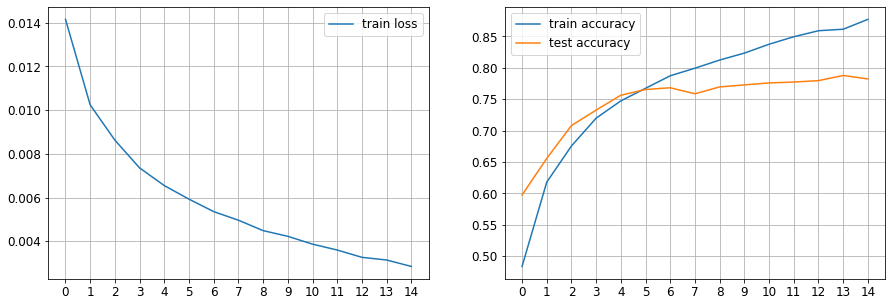

In [ ]:
#Обучение сети
train_rnn_model(net, train_loader, test_loader, loss, num_epochs, updater, clip_value)

### GRU - concat - 2

In [ ]:
class RNNClassifierCustomRNN(nn.Module):
  def __init__(self, vocab_len, embedding_size, rnn_hidden_size,
               num_classes, seq_len, num_layers=1, bidir=False):
    super().__init__()
    self.hidden_dim = rnn_hidden_size
    self.seq_len = seq_len
    self.num_layers = num_layers
    self.bidir = bidir
    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.GRU(embedding_size, rnn_hidden_size,
                      num_layers = num_layers, batch_first=True, bidirectional = bidir)
    self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size * seq_len * (1 + self.bidir), 
                                              rnn_hidden_size),nn.ReLU(), nn.Dropout(0.5),
                                     nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.5)
    
  def forward(self, X):
    #h0 = torch.zeros((1 + self.bidir) * numm, X.size(0), self.hidden_dim).to(device)
    batch_size = X.shape[0]
    
    emb = self.embedding(X) # batch x seq x emb
    out, hidden = self.rnn(emb)
    out = out.reshape(batch_size, -1)
    out = self.dropout(out) # batch x rnn_hidden
    out = self.classifier(out) # batch x num_classes
    return out


vocab_len = vocab.vocab_len
embedding_size = 30
rnn_hidden_size = 256
num_classes = n_classes
seq_len = vocab.max_seq_len
net = RNNClassifierCustomRNN(vocab_len, embedding_size, rnn_hidden_size,
                             num_classes, seq_len, num_layers = 2, bidir=True)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)
clip_value = 5

path = "./Saved models/Surname_task_nn_GRU.pt"
num_epochs = 15

In [ ]:
#Обучение сети
train_rnn_model(net, train_loader, test_loader, loss, num_epochs, updater, clip_value)

  7%|▋         | 1/15 [00:49<11:37, 49.85s/it]

: Loss: 0.0134, Train acc: 0.5072, Test acc: 0.5943


  7%|▋         | 1/15 [01:15<17:32, 75.19s/it]


KeyboardInterrupt: ignored

### GRU - Agg

In [ ]:
a = torch.randn((3, 4, 5))
a

tensor([[[-1.8426,  0.4063, -1.2871, -0.1339,  0.8992],
         [-0.0618, -2.1222, -0.3630,  1.2895, -1.4533],
         [ 1.4204, -0.7981, -1.6971,  0.4383,  0.4343],
         [ 1.9838, -1.9653, -0.2086,  0.2404,  0.4370]],

        [[ 1.0293, -1.6937,  0.5294,  1.1419,  0.9387],
         [ 0.5328, -2.0560, -1.1607,  0.3442,  1.1116],
         [-0.5335, -0.2079, -2.6095, -1.5665, -1.0858],
         [ 0.6119,  0.2198,  0.8738, -2.3508,  0.2340]],

        [[ 0.2689, -1.5889, -0.5631,  1.1674,  1.6456],
         [-0.4633,  0.8441,  1.3646, -1.1029,  0.0565],
         [ 0.4823, -0.4987, -0.5740, -0.1286,  0.2068],
         [ 1.5307, -1.3915, -1.8140, -0.6440,  0.0613]]])

In [ ]:
a.sum(axis=1)

tensor([[ 1.4999, -4.4794, -3.5559,  1.8343,  0.3171],
        [ 1.6405, -3.7378, -2.3669, -2.4312,  1.1986],
        [ 1.8187, -2.6351, -1.5865, -0.7082,  1.9703]])

In [ ]:
class RNNClassifierCustomRNN(nn.Module):
  def __init__(self, vocab_len, embedding_size, rnn_hidden_size, num_classes):
    super().__init__()
    self.hidden_dim = rnn_hidden_size
    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.GRU(embedding_size, rnn_hidden_size, batch_first=True)
    self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size, rnn_hidden_size),nn.ReLU(), nn.Dropout(0.5), nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.5)
    
  def forward(self, X):
    h0 = torch.zeros(1, X.size(0), self.hidden_dim).to(device)
    batch_size = X.shape[0]
    
    emb = self.embedding(X) # batch x seq x emb
    out, hidden = self.rnn(emb, h0)
    out = out.sum(axis=1)
    out = self.dropout(out) # batch x rnn_hidden
    out = self.classifier(out) # batch x num_classes
    return out


vocab_len = vocab.vocab_len
embedding_size = 30
rnn_hidden_size = 256
num_classes = n_classes
net = RNNClassifierCustomRNN(vocab_len, embedding_size, rnn_hidden_size, num_classes)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)
clip_value = 5

path = "./Saved models/Surname_task_nn_GRU.pt"
num_epochs = 15

  7%|▋         | 1/15 [00:06<01:34,  6.78s/it]

: Loss: 0.0150, Train acc: 0.4483, Test acc: 0.5383


 13%|█▎        | 2/15 [00:13<01:27,  6.73s/it]

: Loss: 0.0124, Train acc: 0.5454, Test acc: 0.5838


 20%|██        | 3/15 [00:20<01:21,  6.76s/it]

: Loss: 0.0109, Train acc: 0.5913, Test acc: 0.6321


 27%|██▋       | 4/15 [00:27<01:14,  6.75s/it]

: Loss: 0.0099, Train acc: 0.6330, Test acc: 0.6708


 33%|███▎      | 5/15 [00:33<01:07,  6.73s/it]

: Loss: 0.0090, Train acc: 0.6676, Test acc: 0.6976


 40%|████      | 6/15 [00:40<01:00,  6.74s/it]

: Loss: 0.0082, Train acc: 0.6906, Test acc: 0.7204


 47%|████▋     | 7/15 [00:47<00:54,  6.79s/it]

: Loss: 0.0077, Train acc: 0.7081, Test acc: 0.7236


 53%|█████▎    | 8/15 [00:54<00:47,  6.79s/it]

: Loss: 0.0072, Train acc: 0.7264, Test acc: 0.7350


 60%|██████    | 9/15 [01:00<00:40,  6.81s/it]

: Loss: 0.0069, Train acc: 0.7355, Test acc: 0.7436


 67%|██████▋   | 10/15 [01:07<00:33,  6.78s/it]

: Loss: 0.0065, Train acc: 0.7478, Test acc: 0.7486


 73%|███████▎  | 11/15 [01:16<00:30,  7.54s/it]

: Loss: 0.0061, Train acc: 0.7637, Test acc: 0.7641


 80%|████████  | 12/15 [01:23<00:21,  7.29s/it]

: Loss: 0.0059, Train acc: 0.7719, Test acc: 0.7596


 87%|████████▋ | 13/15 [01:30<00:14,  7.13s/it]

: Loss: 0.0057, Train acc: 0.7773, Test acc: 0.7573


 93%|█████████▎| 14/15 [01:37<00:07,  7.00s/it]

: Loss: 0.0054, Train acc: 0.7860, Test acc: 0.7577


100%|██████████| 15/15 [01:43<00:00,  6.93s/it]

: Loss: 0.0051, Train acc: 0.7980, Test acc: 0.7623


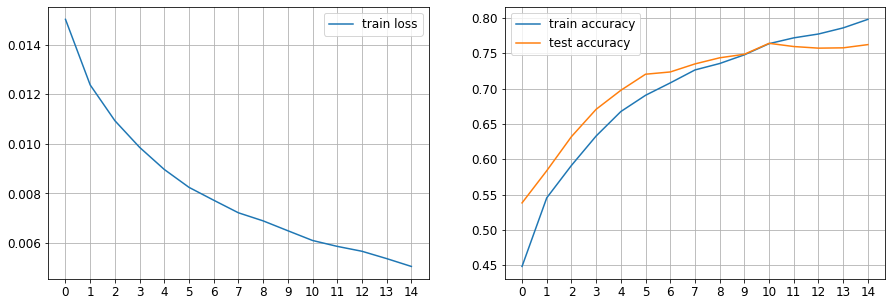

In [ ]:
#Обучение сети
train_rnn_model(net, train_loader, test_loader, loss, num_epochs, updater, clip_value)

### 1.3 Загрузите предобученные эмбеддинги в модуль `nn.Embedding` и обучите модели из 1.2.

(https://disk.yandex.ru/d/BHuT2tEXr_yBOQ?w=1)

In [ ]:
words = []
emb = []
with open("./embeddings/glove.6B.50d.txt") as f:
    while True:
      line = f.readline()
      if not line:
        break
      words.append(line.split(' ')[0])
      emb.append([float(x) for x in line.split(' ')[1:]])

In [ ]:
class Vocab:
     def __init__(self, data):
        tokens = set()
        self.max_seq_len = 0
        for item in data:
            tokens.update(item)
            self.max_seq_len = max(self.max_seq_len, len(item))
        self.unk_token = '<UNK>'
        self.pad_token = '<PAD>'
        self.idx_to_token = dict(enumerate(tokens, 2))
        self.idx_to_token[1] = self.unk_token
        self.idx_to_token[0] = self.pad_token
        self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}
        self.vocab_len = len(self.idx_to_token)
class SurnamesDataset(Dataset):
    def __init__(self, X, y, vocab):
                     self.X = X
                     self.y = y
                     self.vocab = vocab
    def to_sequence(self, surname):
        tok_seq = [self.vocab.token_to_idx[tok] for tok in surname]
        padds_len = self.vocab.max_seq_len - len(tok_seq)
        pad_idx = self.vocab.token_to_idx[self.vocab.pad_token]
        padds = [pad_idx] * padds_len
        return torch.LongTensor(tok_seq + padds)
    def __len__(self):
      return len(self.X)
    def __getitem__(self, idx):
      return self.to_sequence(self.X.iloc[idx]), self.y.iloc[idx]


In [ ]:
len(words)

400000

## 2. Классификация обзоров на фильмы (RNN)

Датасет: https://disk.yandex.ru/d/tdinpb0nN_Dsrg

2.1 Создайте набор данных на основе файлов polarity/positive_reviews.csv (положительные отзывы) и polarity/negative_reviews.csv (отрицательные отзывы). Разбейте на обучающую и тестовую выборку.
  * токен = __слово__
  * данные для обучения в датасете представляются в виде последовательности индексов токенов
  * словарь создается на основе _только_ обучающей выборки. Для корректной обработки ситуаций, когда в тестовой выборке встретится токен, который не хранится в словаре, добавьте в словарь специальный токен `<UNK>`
  * добавьте предобработку текста

2.2. Обучите классификатор.
  
  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding` 
    - подберите адекватную размерность вектора эмбеддинга: 
    - модуль `nn.Embedding` обучается

  * Используйте рекуррентные слои (`nn.RNN`, `nn.LSTM`, `nn.GRU`)


2.3 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)
* Целевое значение accuracy на валидации - 70+%

In [ ]:
review_path = "../Задание 6/"
pos_rev = pd.read_csv(review_path + "data/negative_reviews.txt", sep="\n", header=None, names=["Review"])
pos_rev["Mood"] = 1
neg_rev = pd.read_csv(review_path + "data/positive_reviews.txt", sep="\n", header=None, names=["Review"])
neg_rev["Mood"] = 0
rev_data = pd.concat([pos_rev, neg_rev], ignore_index=True)
rev_data.sample(5)

,Review,Mood
5916,"this is an ungainly movie , ill-fitting , with...",0
4806,a real audience-pleaser that will strike a cho...,1
2390,"it's soulful and unslick , and that's apparent...",1
5808,. . . what a banal bore the preachy circuit t...,0
3412,although devoid of objectivity and full of nos...,1


In [ ]:
X, y = rev_data.Review, rev_data.Mood
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [ ]:
def preprocess_text_2(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    # Replace repetative spaces with only one space
    s = re.sub(r"\s+", ' ', s)

    return s

In [ ]:
def preprocess_text(text: str):
  s = re.sub("[^a-z]", " ", text.lower())
  s = re.sub(r"\s+", ' ', s)
  return s

In [ ]:
def preprocess_text_3(text: str):
  return re.sub(r"[^a-zA-Z0-9\\]", " ", text)

In [ ]:
class Vocab:
  def __init__(self, data: list):
    st = set()
    self.max_seq_len = 0
    for x in data:
      rev = preprocess_text(x)
      rev = nltk.word_tokenize(rev)
      self.max_seq_len = max(self.max_seq_len, len(rev))
      st.update(rev)
    self.unk_token = '<UNK>'
    self.pad_token = '<PAD>'
    #unique_words = [self.pad_token, self.unk_token] + sorted(list(st - set(stopwords.words('english'))))
    unique_words = [self.pad_token, self.unk_token] + sorted(list(st))
    word_ind = list(np.arange(len(unique_words)))
    self.idx_to_token = dict(zip(word_ind, unique_words))
    self.token_to_idx = dict(zip(unique_words, word_ind))
    self.vocab_len = len(unique_words)


class ReviewDataset(Dataset):
  def __init__(self, X, y, vocab: Vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def get_idx(self, review):
    review = preprocess_text(review)
    review = nltk.word_tokenize(review)
    pad_idx = self.vocab.token_to_idx[vocab.pad_token]
    unk_idx = self.vocab.token_to_idx[vocab.unk_token]
    idx = [pad_idx] * self.vocab.max_seq_len
    n = min(len(review), self.vocab.max_seq_len)
    for i in range(n):
      idx[i] = self.vocab.token_to_idx.get(review[i], unk_idx)

    
    return torch.tensor(idx, dtype=torch.int64)


  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    #return self.X.iloc[idx], self.get_idx(self.X.iloc[idx]), self.y.iloc[idx]
    return self.get_idx(self.X.iloc[idx]), self.y.iloc[idx]

In [ ]:
vocab = Vocab(X_train.tolist())
review_train = ReviewDataset(X_train, y_train, vocab)
review_test = ReviewDataset(X_test, y_test, vocab)

batch_size = 32
train_iter = DataLoader(review_train, batch_size, shuffle=True)
test_iter = DataLoader(review_test, batch_size, shuffle=False)

In [ ]:
a = next(iter(train_iter))
a[0][2]

"i can't recommend it . but it's surprisingly harmless ."

In [ ]:
def idx_to_text(idx, vocab):
  text = []
  for x in idx.tolist():
    if x == 0:
      break
    text.append(vocab.idx_to_token[x])
  return text

In [ ]:
a[1][2]

tensor([ 6579,  1869, 13431, 10917,  7210,  1786,  7210, 11575, 13319,  6129,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [ ]:
idx_to_text(a[1][2], vocab)

['i',
 'can',
 't',
 'recommend',
 'it',
 'but',
 'it',
 's',
 'surprisingly',
 'harmless']

In [ ]:
vocab.vocab_len

15408

In [ ]:
True + 1

2

In [ ]:
class GRU_model(nn.Module):
  def __init__(self, vocab_len, embedding_size, rnn_hidden_size,
               num_classes, seq_len, num_layers=1, bidir=False):
    super().__init__()
    self.hidden_dim = rnn_hidden_size
    self.seq_len = seq_len
    self.num_layers = num_layers
    self.bidir = bidir
    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.GRU(embedding_size, rnn_hidden_size,
                      num_layers = num_layers, batch_first=True, bidirectional = bidir)
    self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size * seq_len * (1 + self.bidir), 
                                              rnn_hidden_size),nn.ReLU(), nn.Dropout(0.5),
                                     nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.5)
    
  def forward(self, X):
    #h0 = torch.zeros((1 + self.bidir) * numm, X.size(0), self.hidden_dim).to(device)
    batch_size = X.shape[0]
    
    emb = self.embedding(X) # batch x seq x emb
    out, hidden = self.rnn(emb)
    out = out.reshape(batch_size, -1)
    out = self.dropout(out) # batch x rnn_hidden
    out = self.classifier(out) # batch x num_classes
    return out


vocab_len = vocab.vocab_len
embedding_size = 50
rnn_hidden_size = 128
num_classes = 2
seq_len = vocab.max_seq_len
net = GRU_model(vocab_len, embedding_size, rnn_hidden_size,
                num_classes, seq_len, num_layers = 2)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)
clip_value = 5

path = "./Saved models/Review_task_main.pt"
num_epochs = 15 

 13%|█▎        | 2/15 [00:53<05:46, 26.66s/it]

: Loss: 0.0199, Train acc: 0.6471, Test acc: 0.6311


 20%|██        | 3/15 [01:19<05:16, 26.34s/it]

: Loss: 0.0171, Train acc: 0.7301, Test acc: 0.6699


 27%|██▋       | 4/15 [01:44<04:47, 26.13s/it]

: Loss: 0.0136, Train acc: 0.8064, Test acc: 0.6827


 33%|███▎      | 5/15 [02:11<04:22, 26.29s/it]

: Loss: 0.0098, Train acc: 0.8643, Test acc: 0.6974


 40%|████      | 6/15 [02:39<04:01, 26.80s/it]

: Loss: 0.0063, Train acc: 0.9188, Test acc: 0.7052


 47%|████▋     | 7/15 [03:05<03:33, 26.69s/it]

: Loss: 0.0040, Train acc: 0.9514, Test acc: 0.6987


 53%|█████▎    | 8/15 [03:32<03:05, 26.56s/it]

: Loss: 0.0021, Train acc: 0.9745, Test acc: 0.7024


 60%|██████    | 9/15 [03:58<02:39, 26.58s/it]

: Loss: 0.0016, Train acc: 0.9819, Test acc: 0.7049


 67%|██████▋   | 10/15 [04:24<02:12, 26.42s/it]

: Loss: 0.0011, Train acc: 0.9885, Test acc: 0.7043


 73%|███████▎  | 11/15 [04:50<01:45, 26.31s/it]

: Loss: 0.0007, Train acc: 0.9926, Test acc: 0.7033


 80%|████████  | 12/15 [05:16<01:18, 26.22s/it]

: Loss: 0.0008, Train acc: 0.9890, Test acc: 0.7102


 87%|████████▋ | 13/15 [05:43<00:52, 26.28s/it]

: Loss: 0.0008, Train acc: 0.9925, Test acc: 0.6996


 93%|█████████▎| 14/15 [06:10<00:26, 26.51s/it]

: Loss: 0.0005, Train acc: 0.9944, Test acc: 0.7077


100%|██████████| 15/15 [06:39<00:00, 26.63s/it]

: Loss: 0.0004, Train acc: 0.9952, Test acc: 0.7146


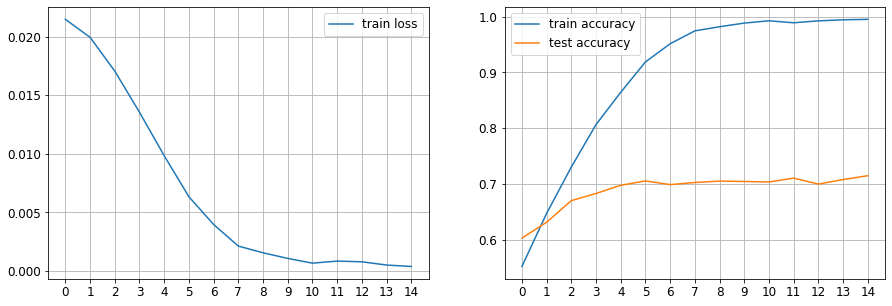

In [ ]:
#Обучение сети
train_rnn_model(net, train_iter, test_iter, loss, num_epochs, updater, clip_value)

### Версия - 2

In [ ]:
class GRU_model(nn.Module):
  def __init__(self, vocab_len, embedding_size, rnn_hidden_size,
               num_classes, seq_len, num_layers=1, bidir=False):
    super().__init__()
    self.hidden_dim = rnn_hidden_size
    self.seq_len = seq_len
    self.num_layers = num_layers
    self.bidir = bidir
    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.GRU(embedding_size, rnn_hidden_size,
                      num_layers = num_layers, batch_first=True, bidirectional = bidir)
    self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size  * (1 + self.bidir), 
                                              rnn_hidden_size),nn.ReLU(), nn.Dropout(0.5),
                                     nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.5)
    
  def forward(self, X):
    #h0 = torch.zeros((1 + self.bidir) * numm, X.size(0), self.hidden_dim).to(device)
    batch_size = X.shape[0]
    
    emb = self.embedding(X) # batch x seq x emb
    out, hidden = self.rnn(emb)
    out = out.sum(axis=1)
    out = self.dropout(out) # batch x rnn_hidden
    out = self.classifier(out) # batch x num_classes
    return out


vocab_len = vocab.vocab_len
embedding_size = 50
rnn_hidden_size = 128
num_classes = 2
seq_len = vocab.max_seq_len
net = GRU_model(vocab_len, embedding_size, rnn_hidden_size,
                num_classes, seq_len, num_layers = 2)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)
clip_value = 5

path = "./Saved models/Review_task_main.pt"
num_epochs = 15 

  7%|▋         | 1/15 [00:24<05:36, 24.04s/it]

: Loss: 0.0230, Train acc: 0.5224, Test acc: 0.5761


 13%|█▎        | 2/15 [00:47<05:08, 23.76s/it]

: Loss: 0.0214, Train acc: 0.5676, Test acc: 0.6255


 20%|██        | 3/15 [01:11<04:44, 23.71s/it]

: Loss: 0.0199, Train acc: 0.6421, Test acc: 0.6633


 27%|██▋       | 4/15 [01:34<04:20, 23.70s/it]

: Loss: 0.0171, Train acc: 0.7327, Test acc: 0.6862


 33%|███▎      | 5/15 [01:58<03:56, 23.66s/it]

: Loss: 0.0138, Train acc: 0.8053, Test acc: 0.7099


 40%|████      | 6/15 [02:22<03:32, 23.62s/it]

: Loss: 0.0110, Train acc: 0.8525, Test acc: 0.7224


 47%|████▋     | 7/15 [02:45<03:08, 23.57s/it]

: Loss: 0.0082, Train acc: 0.8972, Test acc: 0.7305


 53%|█████▎    | 8/15 [03:10<02:48, 24.06s/it]

: Loss: 0.0057, Train acc: 0.9345, Test acc: 0.7215


 60%|██████    | 9/15 [03:34<02:23, 23.88s/it]

: Loss: 0.0034, Train acc: 0.9611, Test acc: 0.7234


 67%|██████▋   | 10/15 [03:57<01:58, 23.77s/it]

: Loss: 0.0022, Train acc: 0.9731, Test acc: 0.7284


 73%|███████▎  | 11/15 [04:21<01:35, 23.80s/it]

: Loss: 0.0013, Train acc: 0.9874, Test acc: 0.7234


 80%|████████  | 12/15 [04:50<01:16, 25.48s/it]

: Loss: 0.0006, Train acc: 0.9941, Test acc: 0.7171


 87%|████████▋ | 13/15 [05:19<00:52, 26.36s/it]

: Loss: 0.0005, Train acc: 0.9948, Test acc: 0.7146


 93%|█████████▎| 14/15 [05:48<00:27, 27.10s/it]

: Loss: 0.0004, Train acc: 0.9962, Test acc: 0.7243


100%|██████████| 15/15 [06:18<00:00, 25.22s/it]

: Loss: 0.0004, Train acc: 0.9956, Test acc: 0.7265


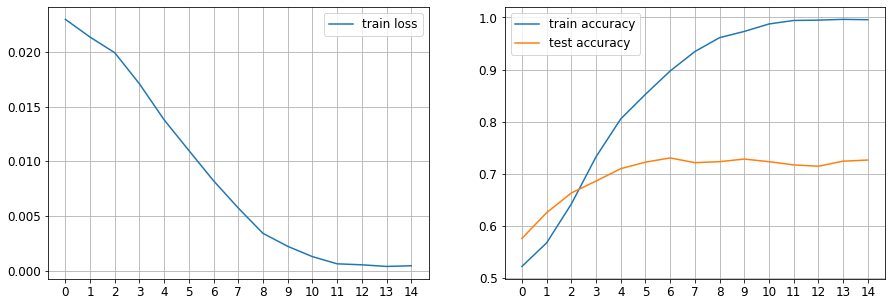

In [ ]:
#Обучение сети
train_rnn_model(net, train_iter, test_iter, loss, num_epochs, updater, clip_value)

### Версия 3

In [ ]:
class GRU_model(nn.Module):
  def __init__(self, vocab_len, embedding_size, rnn_hidden_size,
               num_classes, seq_len, num_layers=1, bidir=False):
    super().__init__()
    self.hidden_dim = rnn_hidden_size
    self.seq_len = seq_len
    self.num_layers = num_layers
    self.bidir = bidir
    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.GRU(embedding_size, rnn_hidden_size,
                      num_layers = num_layers, batch_first=True, bidirectional = bidir)
    self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size  * (1 + self.bidir), 
                                              rnn_hidden_size),nn.ReLU(), nn.Dropout(0.5),
                                     nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.5)
    
  def forward(self, X):
    #h0 = torch.zeros((1 + self.bidir) * numm, X.size(0), self.hidden_dim).to(device)
    batch_size = X.shape[0]
    
    emb = self.embedding(X) # batch x seq x emb
    out, hidden = self.rnn(emb)
    out = out.sum(axis=1)
    out = self.dropout(out) # batch x rnn_hidden
    out = self.classifier(out) # batch x num_classes
    return out


vocab_len = vocab.vocab_len
embedding_size = 64
rnn_hidden_size = 256
num_classes = 2
seq_len = vocab.max_seq_len
net = GRU_model(vocab_len, embedding_size, rnn_hidden_size,
                num_classes, seq_len, num_layers = 2)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)
clip_value = 5

path = "./Saved models/Review_task_main.pt"
num_epochs = 15 

In [ ]:
#Обучение сети
train_rnn_model(net, train_iter, test_iter, loss, num_epochs, updater, clip_value)

  7%|▋         | 1/15 [00:59<13:49, 59.27s/it]

: Loss: 0.0226, Train acc: 0.5482, Test acc: 0.5914


 13%|█▎        | 2/15 [01:57<12:39, 58.42s/it]

: Loss: 0.0205, Train acc: 0.6181, Test acc: 0.6364


 13%|█▎        | 2/15 [02:39<17:14, 79.59s/it]


KeyboardInterrupt: ignored

### Другое

In [ ]:
class GRU_model(nn.Module):
  def __init__(self, vocab_len, embedding_size, rnn_hidden_size, num_classes):
    super().__init__()
    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.GRU(embedding_size, rnn_hidden_size, batch_first=True)
    self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size, rnn_hidden_size),nn.ReLU(), nn.Dropout(0.5), nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.5)

    
  def forward(self, X):
    out = self.embedding(X) # batch x seq x emb
    out = torch.squeeze(self.rnn(out)[1]) # batch x rnn_hidden
    out = self.dropout(out) # batch x rnn_hidden
    out = self.classifier(out) # batch x num_classes
    return out


vocab_len = vocab.vocab_len
embedding_size = 128
rnn_hidden_size = 256
num_classes = 2
net = GRU_model(vocab_len, embedding_size, rnn_hidden_size, num_classes)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)

task_path = "./Saved models/"
file_name = "Review_task_extra.pt"
num_epochs = 25 

In [ ]:
def compute_accuracy(y_hat, y):
  # Считаем кол-во верных ответов (работает для ответов - векторов)
  y_hat = y_hat.argmax(axis=1)
  correct_mask = y_hat == y
  return correct_mask.sum()

def evaluate_accuracy(net, test_iter):
  # Выставляем режим оценки модели
  net.eval()

  total_samples = len(test_iter.dataset) #Общее кол-во элементво в выборке
  correct_samples = 0 

  with torch.no_grad():
    for X, y in test_iter:
      X, y = X.to(device), y.to(device)

      y_hat = net(X)
      correct_samples += compute_accuracy(y_hat, y)

  return correct_samples / total_samples


def train_epoch(net, train_iter, loss, updater, clip = 5):
  # Выставляем режим обучения модели
  net.train()

  total_samples = len(train_iter.dataset)
  correct_samples = 0
  total_loss = 0

  for X, y in train_iter:
    X, y = X.to(device), y.to(device)

    y_hat = net(X)
    l = loss(y_hat, y)

    updater.zero_grad()
    l.backward()
    nn.utils.clip_grad_norm_(net.parameters(), clip)
    updater.step()

    total_loss += l
    correct_samples += compute_accuracy(y_hat, y)
    
  return total_loss / total_samples, correct_samples / total_samples


class Model_metrics:
  def __init__(self):
    self.train_loss = []
    self.train_accuracy = []
    self.test_accuracy = []
  
  def add(self, train_loss, train_accuracy, test_accuracy):
      self.train_loss.append(train_loss.cpu().item())
      self.train_accuracy.append(train_accuracy.cpu().item())
      self.test_accuracy.append(test_accuracy.cpu().item())
  
  def plot(self):
      plt.rcParams.update({'font.size': 12})
      fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
      epochs = np.arange(len(self.train_loss))

      # График функции потерь
      ax[0].plot(epochs, self.train_loss, label="train loss")
      ax[0].set_xticks(epochs)
      ax[0].grid()
      ax[0].legend()

      # График точности на обучении и тесте
      ax[1].plot(epochs, self.train_accuracy, label="train accuracy")
      ax[1].plot(epochs, self.test_accuracy, label="test accuracy")
      ax[1].set_xticks(epochs)
      ax[1].grid()
      ax[1].legend()

      plt.show()


  def return_dict(self):
    res = {
        "train_loss": self.train_loss,
        "train_accuracy": self.train_accuracy,
        "test_accuracy": self.test_accuracy
    }
    return res


def saving(net, model_metrics, task_path, file_name):
  state = {"state_dict": net.state_dict()}
  metrics_dict = model_metrics.return_dict()
  state = {**state, **metrics_dict}
  torch.save(state, task_path + file_name)


def train_model_rnn(net, train_iter, test_iter, loss, 
                num_epochs, updater, task_path, file_name):
    
  model_metrics = Model_metrics()
  for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train_epoch(net, train_iter, loss, updater)
    test_accuracy = evaluate_accuracy(net, test_iter)
    model_metrics.add(train_loss, train_accuracy, test_accuracy)
    #if epoch % 5 == 0:
    #print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train acc: {train_accuracy:.4f}, Test acc: {test_accuracy:.4f}')
    print (f': Loss: {train_loss:.4f}, Train acc: {train_accuracy:.4f}, Test acc: {test_accuracy:.4f}')
  model_metrics.plot()
  saving(net, model_metrics, task_path, file_name)

In [ ]:
#Обучение сети
train_model_rnn(net, train_iter, test_iter, loss, num_epochs, updater, task_path, file_name)

  4%|▍         | 1/25 [00:35<14:14, 35.61s/it]

: Loss: 0.0218, Train acc: 0.4994, Test acc: 0.4952


  8%|▊         | 2/25 [01:10<13:30, 35.26s/it]

: Loss: 0.0218, Train acc: 0.4837, Test acc: 0.5055


 12%|█▏        | 3/25 [01:45<12:47, 34.88s/it]

: Loss: 0.0217, Train acc: 0.5003, Test acc: 0.5052


 16%|█▌        | 4/25 [02:18<12:04, 34.49s/it]

: Loss: 0.0217, Train acc: 0.5025, Test acc: 0.4952


 20%|██        | 5/25 [02:52<11:25, 34.26s/it]

: Loss: 0.0217, Train acc: 0.4991, Test acc: 0.4948


 24%|██▍       | 6/25 [03:26<10:46, 34.02s/it]

: Loss: 0.0217, Train acc: 0.4979, Test acc: 0.5048


 28%|██▊       | 7/25 [04:00<10:10, 33.91s/it]

: Loss: 0.0217, Train acc: 0.5052, Test acc: 0.4952


 32%|███▏      | 8/25 [04:33<09:35, 33.83s/it]

: Loss: 0.0217, Train acc: 0.4932, Test acc: 0.5045


 36%|███▌      | 9/25 [05:07<09:00, 33.79s/it]

: Loss: 0.0216, Train acc: 0.5152, Test acc: 0.5023


 40%|████      | 10/25 [05:41<08:26, 33.75s/it]

: Loss: 0.0216, Train acc: 0.5113, Test acc: 0.4961


 44%|████▍     | 11/25 [06:14<07:52, 33.76s/it]

: Loss: 0.0215, Train acc: 0.5109, Test acc: 0.4942


 48%|████▊     | 12/25 [06:48<07:18, 33.71s/it]

: Loss: 0.0214, Train acc: 0.5186, Test acc: 0.5052


 52%|█████▏    | 13/25 [07:22<06:44, 33.69s/it]

: Loss: 0.0213, Train acc: 0.5236, Test acc: 0.5027


 52%|█████▏    | 13/25 [07:46<07:10, 35.88s/it]


KeyboardInterrupt: ignored